# DACON_컴퓨터비전학습경진대회 연습
## 정확도 90%

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf

In [2]:
# GPU 사용을 위한 코드
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical CPU, 1 Logical CPU


In [3]:
# Load Data
train = pd.read_csv('D:/DACON_MNIST/data/train.csv')
test = pd.read_csv('D:/DACON_MNIST/data/test.csv')

In [4]:
# train data는 id, digit, letter, pixel 로 구성되어 있다.
print(train.head(5))
# test data는 id, letter, pixel로 구성되어 있다.
print(test.head(5))
# submission은 id와 digit로 구성되어 있다.
print(len(train))
print(len(test))

   id  digit letter  0  1  2  3  4  5  6  ...  774  775  776  777  778  779  \
0   1      5      L  1  1  1  4  3  0  0  ...    2    1    0    1    2    4   
1   2      0      B  0  4  0  0  4  1  1  ...    0    3    0    1    4    1   
2   3      4      L  1  1  2  2  1  1  1  ...    3    3    3    0    2    0   
3   4      9      D  1  2  0  2  0  4  0  ...    3    3    2    0    1    4   
4   5      6      A  3  0  2  4  0  3  0  ...    4    4    3    2    1    3   

   780  781  782  783  
0    4    4    3    4  
1    4    2    1    2  
2    3    0    2    2  
3    0    0    1    1  
4    4    3    1    2  

[5 rows x 787 columns]
     id letter  0  1  2  3  4  5  6  7  ...  774  775  776  777  778  779  \
0  2049      L  0  4  0  2  4  2  3  1  ...    2    0    4    2    2    4   
1  2050      C  4  1  4  0  1  1  0  2  ...    0    3    2    4    2    4   
2  2051      S  0  4  0  1  3  2  3  0  ...    1    3    2    0    3    2   
3  2052      K  2  1  3  3  3  4  3  0  ...    3 

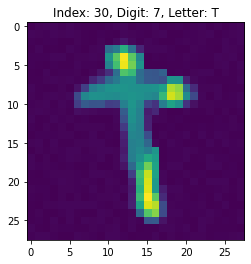

In [5]:
# train 데이터에 있는 이미지 출력해보기(Index에 있는 이미지, 이미지에 해당하는 숫자와 문자)
idx = 30
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

In [6]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

# Kfold - train과 test로만 나눔(사용하지 않을 column drop시킴)
train2 = train.drop(['id', 'digit', 'letter'], axis=1).values
test2 = test.drop(['id','letter'], axis=1).values

# reshape
train2 = train2.reshape(-1,28,28,1)
test2 = test2.reshape(-1,28,28,1)

# normalization
train2 = train2/255.0
test2 = test2/255.0

Using TensorFlow backend.


In [7]:
# 이미지 Augmentation(test generator는 valid와 test에 사용됨)
from keras.preprocessing.image import ImageDataGenerator
idg_train = ImageDataGenerator(height_shift_range=(-1,1),width_shift_range=(-1,1))
idg_test = ImageDataGenerator()

In [20]:
from sklearn.model_selection import StratifiedKFold
# New - StratifiedKFold : fold 안의 데이터셋의 label 분포가 전체 데이터셋의 label분포를 따름
# 각 fold가 전체 데이터셋을 잘 대표함
# n_splits : fold의 개수, shuffle : 샘플 순서 랜덤, random_states : 고정해서 ㄸ고같은 작업을 재현할 수 있음)
skf = StratifiedKFold(n_splits=2, random_state=10, shuffle=True)

In [23]:
# 훈련시키면서 가장 정확도가 높은 모델 저장하는 방법 : ModelCheckpoint
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.layers import *
from keras import Sequential

reLR = ReduceLROnPlateau(patience=15,verbose=1,factor=0.5) #learning rate scheduler
es = EarlyStopping(patience=20, verbose=1)

val_loss_min = []
result = 0
nth = 0

# train, valid set으로 나눠서 실행
for train_index, valid_index in skf.split(train2,train['digit']) :
    
    checkpointer = ModelCheckpoint(filepath='D:/DACON_MNIST/data/model.weights.best.hdf5', verbose = 1, save_best_only=True)
    
    # train을 x_train, x_valid로 나눔
    x_train = train2[train_index]
    x_valid = train2[valid_index]    
    # train y_train, y_valid로 나눔
    y_train = train['digit'][train_index]
    y_valid = train['digit'][valid_index]
    
    # data generator 적용
    train_generator = idg_train.flow(x_train,y_train,batch_size=32)
    valid_generator = idg_test.flow(x_valid,y_valid)
    test_generator = idg_test.flow(test2,shuffle=False)
    
    model = Sequential()
    
    model.add(Conv2D(16,(3,3),activation='relu',input_shape=(28,28,1),padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(5,5),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(5,5),activation='relu',padding='same')) 
    model.add(BatchNormalization())
    model.add(MaxPooling2D((3,3)))
    model.add(Dropout(0.3))

    model.add(Flatten())

    model.add(Dense(128,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Dense(64,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(10,activation='softmax'))

    # 모델 compile(loss, optimizer 등 설정)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # 모델 학습 수행
    learning_history = model.fit_generator(train_generator,epochs=200, validation_data=valid_generator,callbacks=[es,checkpointer,reLR])
    
    # predict
    model.load_weights('D:/DACON_MNIST/data/model.weights.best.hdf5')
    result += model.predict_generator(test_generator,verbose=True)/40
    
    # save val_loss
    hist = pd.DataFrame(learning_history.history)
    val_loss_min.append(hist['val_loss'].min())
    
    nth += 1
    print(nth, '번째 학습을 완료했습니다.')


Epoch 1/200
52/52 [==============================] - 16s 309ms/step - loss: 2.9527 - accuracy: 0.1258 - val_loss: 2.7280 - val_accuracy: 0.1000

Epoch 00001: val_loss improved from inf to 2.72800, saving model to D:/DACON_MNIST/data/model.weights.best.hdf5
Epoch 2/200
52/52 [==============================] - 14s 273ms/step - loss: 2.4643 - accuracy: 0.1966 - val_loss: 2.8844 - val_accuracy: 0.1000

Epoch 00002: val_loss did not improve from 2.72800
Epoch 3/200
52/52 [==============================] - 14s 274ms/step - loss: 2.2106 - accuracy: 0.2485 - val_loss: 3.5093 - val_accuracy: 0.1000

Epoch 00003: val_loss did not improve from 2.72800
Epoch 4/200
52/52 [==============================] - 14s 277ms/step - loss: 2.0770 - accuracy: 0.2845 - val_loss: 5.2710 - val_accuracy: 0.1000

Epoch 00004: val_loss did not improve from 2.72800
Epoch 5/200
52/52 [==============================] - 14s 273ms/step - loss: 1.9217 - accuracy: 0.3278 - val_loss: 6.1445 - val_accuracy: 0.1000

Epoch 0000


Epoch 00039: val_loss did not improve from 0.11219
Epoch 40/200
52/52 [==============================] - 15s 281ms/step - loss: 0.4114 - accuracy: 0.8840 - val_loss: 0.3702 - val_accuracy: 0.8902

Epoch 00040: val_loss did not improve from 0.11219
Epoch 41/200
52/52 [==============================] - 15s 281ms/step - loss: 0.3844 - accuracy: 0.8675 - val_loss: 0.8669 - val_accuracy: 0.8293

Epoch 00041: val_loss did not improve from 0.11219
Epoch 42/200
52/52 [==============================] - 14s 277ms/step - loss: 0.3338 - accuracy: 0.8828 - val_loss: 0.4067 - val_accuracy: 0.8805

Epoch 00042: val_loss did not improve from 0.11219
Epoch 43/200
52/52 [==============================] - 14s 273ms/step - loss: 0.3392 - accuracy: 0.8834 - val_loss: 0.5544 - val_accuracy: 0.7659

Epoch 00043: val_loss did not improve from 0.11219
Epoch 44/200
52/52 [==============================] - 15s 279ms/step - loss: 0.4228 - accuracy: 0.8657 - val_loss: 0.4647 - val_accuracy: 0.8707

Epoch 00044: v

KeyboardInterrupt: 

In [ ]:
display(val_loss_min, np.mean(val_loss_min))

In [ ]:
model.summary()

In [ ]:
# submission의 'digit'에 예측한 결과값을 적어줌
submission = pd.read_csv('D:/DACON_MNIST/data/submission.csv')
submission['digit'] = result.argmax(1)

In [ ]:
# 결과를 csv파일로 저장함
submission.to_csv('D:/DACON_MNIST/data/DACON_MNIST_03.csv', index=False)

In [ ]:
# 모델 학습 결과 그래프로 확인하기
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(learning_history.history['loss'])
plt.plot(learning_history.history['accuracy'])
plt.title('Model loss & accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()
print(learning_history.history['accuracy'][-5:])